In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

In [2]:
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

# Design Generator and Dicriminator

In [3]:
class Generator(nn.Module):
    """docstring for Generator."""
    def __init__(self):
        super(Generator, self).__init__()
        self.d = 128
        self.linear1 = nn.Linear(100, self.d)
        self.linear2 = nn.Linear(self.d, self.d * 2)
        self.linear3 = nn.Linear(self.d * 2, self.d * 4)
        self.linear4 = nn.Linear(self.d * 4, 784)

    def forward(self, inputs):
        x = F.leaky_relu(self.linear1(inputs), 0.2)
        x = F.leaky_relu(self.linear2(x), 0.2)
        x = F.leaky_relu(self.linear3(x), 0.2)
        x = F.tanh(self.linear4(x))

        return x
    
    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

class Discriminator(nn.Module):
    """docstring for Discriminator."""
    def __init__(self):
        super(Discriminator, self).__init__()
        self.d = 128
        self.linear1 = nn.Linear(784, self.d * 4)
        self.linear2 = nn.Linear(self.d * 4, self.d * 2)
        self.linear3 = nn.Linear(self.d * 2, self.d)
        self.linear4 = nn.Linear(self.d, 1)

    # forward method
    def forward(self, inputs):
        x = F.leaky_relu(self.linear1(inputs), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.linear2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.linear3(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.sigmoid(self.linear4(x))
        return x
    
    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)




# Test Generator and Discriminator

In [4]:
z = torch.randn((128, 100))   # fixed noise
z = Variable(z, volatile=True)
generator_test = Generator()
z_conv = generator_test.forward(z)
print(z_conv.size())
plt.show()

torch.Size([128, 784])


In [5]:
discrimintaor_test = Discriminator()
pred_z_conv = discrimintaor_test(z_conv)
print(pred_z_conv.size())

torch.Size([128, 1])


# Load dataset

In [6]:
# MNIST dataset

#transform = transforms.Compose(
#    [torchvision.transforms.Resize((64, 64)),
#        transforms.ToTensor()],)

transform = transforms.Compose([
        #torchvision.transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

dataset = torchvision.datasets.MNIST(root='./data',
                         train=True,
                         transform=transform,
                         download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=128, 
                                          shuffle=True)

# Test on images

torch.Size([128, 1, 28, 28])


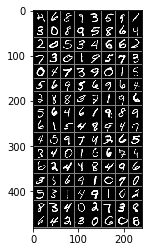

In [7]:
# get some random training images
dataiter = iter(data_loader)
images, labels = dataiter.next()
print(images.size())
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# show images
imshow(torchvision.utils.make_grid(images))
plt.show()

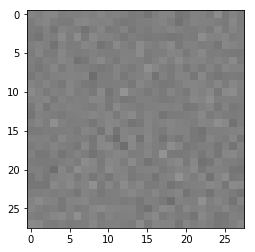

In [8]:
z = torch.randn((128, 100))   # fixed noise
z = Variable(z, volatile=True)
generator_test = Generator()
image = generator_test.forward(z)
img = image.cpu().data
imshow(torchvision.utils.make_grid(img[0].view(28,28)))
plt.show()

In [9]:
img = Variable(images)
print(img.size())
img = img.view(-1, 28*28)
pred_img_conv = discrimintaor_test(img)
print(pred_img_conv.size())

torch.Size([128, 1, 28, 28])
torch.Size([128, 1])


# Design model

In [10]:
def extract(v):
    return v.data.storage().tolist()

d_steps = 1  # 'k' steps in the original GAN paper. Can put the discriminator on higher training freq than generator
g_steps = 1
d_learning_rate = 2e-4  # 2e-4
g_learning_rate = 2e-4
optim_betas = (0.5, 0.999)
print_interval = 1
n_epoch = 100
#(name, preprocess, d_input_func) = ("Data and variances", lambda data: decorate_with_diffs(data, 2.0), lambda x: x * 2)

# Training

In [11]:
#Define network
G = Generator()
D = Discriminator()
G.cuda()
D.cuda()
G.weight_init(mean=0.0, std=0.02)
D.weight_init(mean=0.0, std=0.02)

#Define Learning
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr=d_learning_rate, betas=optim_betas)
g_optimizer = optim.Adam(G.parameters(), lr=g_learning_rate, betas=optim_betas)
G_loss = []
D_loss = []

In [12]:
for epoch in range(n_epoch):
    for i, data in enumerate(data_loader):
        D.zero_grad()

        #Compute gradient fake data
        img, _ = data
        batch_size = img.size()[0]
        real_data = Variable(img.cuda()).view(-1, 28*28)
        real_output = D(real_data)
        real_error = criterion(real_output.view(batch_size), Variable(torch.ones(batch_size).cuda()))
        real_error.backward()

        #compute grad fake data
        z = torch.randn(batch_size, 100)    # fixed noise
        d_noise = Variable(z.cuda(), volatile = False) #volatile ? To compute grad ==> volatile = False
        fake_output = G(d_noise).detach()
        fake_class = D(fake_output)
        fake_error = criterion(fake_class.view(batch_size), Variable(torch.zeros(batch_size).cuda())) #fake_class.view(100) ok ?
        fake_error.backward()
        d_optimizer.step()

        G.zero_grad()

        z = torch.randn(batch_size, 100)    # fixed noise
        g_noise = Variable(z.cuda())
        g_fake_data = G(g_noise)
        g_fake_decision = D(g_fake_data)
        g_error = criterion(g_fake_decision.view(batch_size), Variable(torch.ones(batch_size).cuda()))
        g_error.backward()
        g_optimizer.step()
        
        G_loss.append(extract(g_error)[0])
        D_loss.append(extract(real_error)[0] + extract(fake_error)[0])



    print("%s: D: %s/%s G: %s " % (epoch,
                                        extract(real_error)[0],
                                        extract(fake_error)[0],
                                        extract(g_error)[0],
                                        ))

0: D: 0.09510675072669983/0.370565265417099 G: 3.966588020324707 
1: D: 0.03581090644001961/0.13339151442050934 G: 4.419440746307373 
2: D: 0.03585157170891762/0.2966732382774353 G: 5.307615756988525 
3: D: 0.19487357139587402/0.03210083767771721 G: 1.5220543146133423 
4: D: 0.23647721111774445/0.04490178823471069 G: 2.3336734771728516 
5: D: 0.10179374366998672/0.04909747466444969 G: 3.0957868099212646 
6: D: 0.098907969892025/0.2157568484544754 G: 3.051060676574707 
7: D: 0.3005293607711792/0.055888328701257706 G: 1.8923648595809937 
8: D: 0.15058769285678864/0.3256300985813141 G: 3.452681303024292 
9: D: 0.24368828535079956/0.08024558424949646 G: 2.0006141662597656 
10: D: 0.31561198830604553/0.12153566628694534 G: 1.696034550666809 
11: D: 0.18273717164993286/0.25465118885040283 G: 2.427170515060425 
12: D: 0.43646183609962463/0.2015494704246521 G: 1.6308588981628418 
13: D: 0.21132667362689972/0.554589569568634 G: 2.996461868286133 
14: D: 0.812014102935791/0.12971532344818115 G: 

# Results

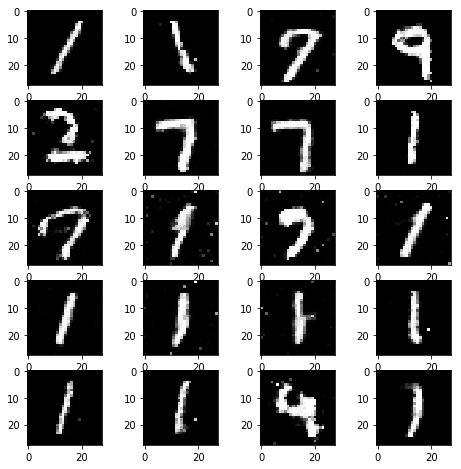

In [21]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    z = torch.randn((128, 100))    # fixed noise
    z = Variable(z.cuda(), volatile=True)
    images = G(z)
    img = images.cpu().data
    fig.add_subplot(rows, columns, i)
    imshow(torchvision.utils.make_grid(img[0].view(28,28)))
plt.show()
fig.savefig('GAN_100epochs.png', bbox_inches='tight')

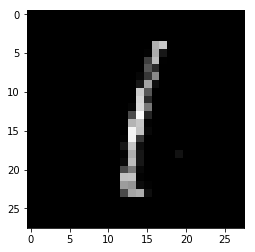

In [14]:
z = torch.randn((128, 100))    # fixed noise
z = Variable(z.cuda(), volatile=True)
images = G(z)
img = images.cpu().data
imshow(torchvision.utils.make_grid(img[0].view(28,28)))
plt.show()

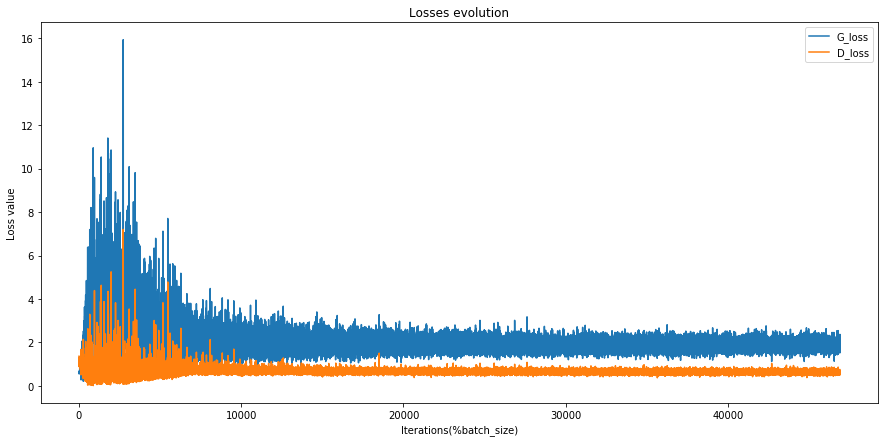

In [16]:
absc = np.linspace(0, len(G_loss), len(G_loss))
fig=plt.figure(figsize=(15, 7))
plt.plot(absc, G_loss, label = "G_loss")
plt.plot(absc, D_loss, label = "D_loss")
plt.title("Losses evolution")
plt.ylabel("Loss value")
plt.xlabel("Iterations(%batch_size)")
plt.legend()
plt.show()
fig.savefig('loss_GAN_100epochs.png', bbox_inches='tight')